In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_14857/510495331.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
def createSomeData(nPerClust):
    A=[1,1]
    B=[5,1]
    C=[4,4]
    a=[A[0]+np.random.randn(nPerClust),A[1]+np.random.randn(nPerClust)]
    b=[B[0]+np.random.randn(nPerClust),B[1]+np.random.randn(nPerClust)]
    c=[C[0]+np.random.randn(nPerClust),C[1]+np.random.randn(nPerClust)]
    labels_np=np.hstack((np.zeros((nPerClust)),
                        np.ones((nPerClust)),
                        1+np.ones((nPerClust))))
    data_np=np.hstack((a,b,c)).T
    output={}
    output['data']=torch.tensor(data_np).float()
    output['labels']=torch.tensor(labels_np).long()
    train_data,test_data,train_labels,test_labels=train_test_split(output['data'],output['labels'])
    train_data=TensorDataset(train_data,train_labels)
    test_data=TensorDataset(test_data,test_labels)
    batchsize=8
    output['train_data']=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    output['test_data']=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0],shuffle=True,drop_last=False)
    return output

    

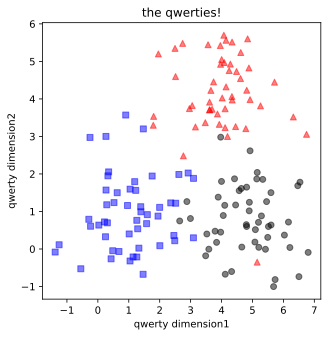

In [3]:
theData=createSomeData(50)
data=theData['data']
labels=theData['labels']
figure=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=0.5)
plt.title('the qwerties!')
plt.xlabel('qwerty dimension1')
plt.ylabel('qwerty dimension2')
plt.show()


In [6]:
def createTheQwertyNet(nUnits,nLayers):
    class qwertyNet(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
            self.layers=nn.ModuleDict()
            self.nLayers=nLayers
            
            self.layers['input']=nn.Linear(2,nUnits)
            for i in range(nLayers):
                self.layers[f'hidden{i}']=nn.Linear(nUnits,nUnits)
            self.layers['output']=nn.Linear(nUnits,3)
            
            
        def forward(self,x):
            
            x=self.layers['input'](x)
            for i in range(self.nLayers):
                x=F.relu(self.layers[f'hidden{i}'](x))
            
            x=self.layers['output'](x)
            
            return x
        
    net=qwertyNet(nUnits,nLayers)
    
    lossfun=nn.CrossEntropyLoss()
    
    optimizer=torch.optim.SGD(net.parameters(),lr=0.01)
    
    return net,lossfun,optimizer

     
        
        
        
        
            
            

In [7]:
nUnitsPerLayer=12
nLayers=4
net,lossfun,optimizer=createTheQwertyNet(nUnitsPerLayer,nLayers)
print(net)
inputt=torch.rand(10,2)
net(inputt)

qwertyNet(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[-0.0812,  0.0842, -0.0403],
        [-0.0822,  0.0843, -0.0416],
        [-0.0796,  0.0841, -0.0380],
        [-0.0799,  0.0841, -0.0383],
        [-0.0795,  0.0842, -0.0378],
        [-0.0830,  0.0844, -0.0435],
        [-0.0820,  0.0843, -0.0414],
        [-0.0785,  0.0841, -0.0362],
        [-0.0803,  0.0842, -0.0390],
        [-0.0819,  0.0843, -0.0416]], grad_fn=<AddmmBackward0>)

In [16]:
def func2trainTheModel(nUnits,nLayers):
    numepochs=50
    net,lossfun,optimizer=createTheQwertyNet(nUnits,nLayers)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        batchAcc=[]
        batchLoss=[]
        for X,y in train_data:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            
            matches=torch.argmax(yHat,axis=1)==y
            matchesNumeric=matches.float()
            accuracyPct=100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
            
        trainAcc.append(torch.mean(torch.tensor(batchAcc)))
        losses[epochi]=np.mean(batchLoss)
        
        X,y=next(iter(test_data))
        with torch.no_grad():
            yHat=net(X)
        
        matches=torch.argmax(yHat,axis=1)==y
        matchesNumeric=matches.float()
        accuracyPct=100*torch.mean(matchesNumeric)
        testAcc.append(accuracyPct)
        
    return trainAcc,testAcc,losses,net
            
            
        
    

In [17]:
theData=createSomeData(200)
train_data=theData['train_data']
test_data=theData['test_data']
trainAcc,testAcc,losses,net=func2trainTheModel(80,1)

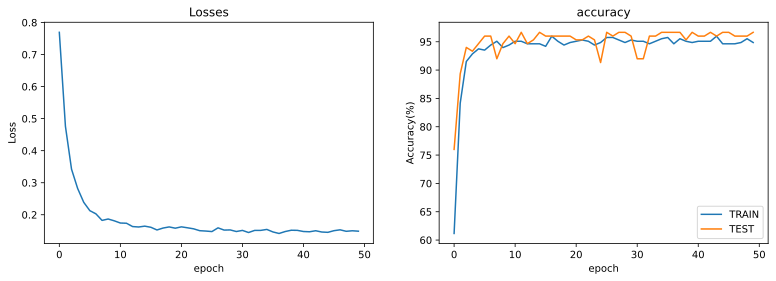

In [19]:
fig,ax=plt.subplots(1,2,figsize=(13,4))
ax[0].plot(losses.detach())
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[1].plot(trainAcc,label='TRAIN')
ax[1].plot(testAcc,label='TEST')

ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy(%)')

ax[1].set_title('accuracy')
ax[1].legend()
plt.show()

In [21]:
nNodesInModel=80
layersRange=[1,5,10,20]
nDatapoints=np.arange(50,551,50)

legend=[]
for lidx,layers in enumerate(layersRange):
    unitsperlayer=int(nNodesInModel/layersRange[lidx])
    net=createTheQwertyNet(unitsperlayer,layers)[0]
    nparams=np.sum([p.numel() for p in net.parameters() if p.requires_grad])
    legend.append(f"{layers} layers, {unitsperlayer} units, {nparams} params")
    print(f"{layers} layers, {unitsperlayer} units, {nparams} params")

1 layers, 80 units, 6963 params
5 layers, 16 units, 1459 params
10 layers, 8 units, 771 params
20 layers, 4 units, 427 params


In [25]:
 for p in net.parameters():
#         print(p)

        print(p.numel())

8
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
16
4
12
3


In [26]:
results=np.zeros((len(nDatapoints),len(layersRange),2))
for didx,pnts in enumerate(nDatapoints):
    theData=createSomeData(pnts)
    train_data=theData['train_data']
    test_data=theData['test_data']
    
    for lidx,layers in enumerate(layersRange):
        unitsperlayer=int(nNodesInModel/layersRange[lidx])
        trainAcc,testAcc,losses,net=func2trainTheModel(unitsperlayer,layers)
        results[didx,lidx,0]=np.mean(testAcc[-5:])
        results[didx,lidx,1]=torch.mean(losses[-5:]).item()
        
        

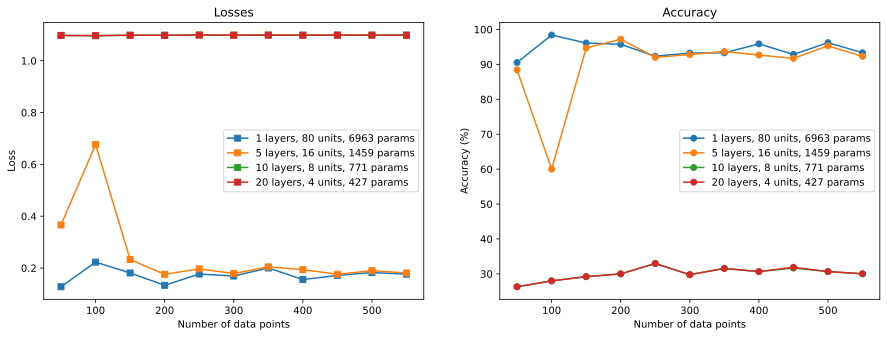

In [27]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(nDatapoints,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDatapoints,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].legend(legend)
ax[1].set_title('Accuracy')
plt.show()
